In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# ENABLE IF USING COLAB
USE_COLAB = True

if USE_COLAB:
    import os
    import shutil
    from google.colab import drive
    
    FOLDERNAME = 'UMass_Amherst/NN_AMI/NN_Project'
    drive.mount('/content/drive')
    %cd /content/drive/My\ Drive/$FOLDERNAME

    if os.path.exists('./spectroconv/'):
      %cd ./spectroconv
      !pip install hub
      !pip install hub[audio]
    else:
      print("Error, must first pull project repository from github to Drive using ColabGitCommands.ipynb")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UMass_Amherst/NN_AMI/NN_Project
/content/drive/My Drive/UMass_Amherst/NN_AMI/NN_Project/spectroconv


In [37]:
from data_utils import nsynth_adapter as na
from matplotlib import pyplot as plt
from models import train_model, cnn_model
import numpy as np
import torch

In [38]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using cuda")


Wed Apr 13 01:42:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |   1405MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
token = None
with open('./api_key') as f:
    token = f.read().strip()
n_mels = 128
train_source = f"hub://jakeval/nsynth-full-{n_mels}-train"
validate_source = f"hub://jakeval/nsynth-full-{n_mels}-validate"

## Train on the full dataset

In [40]:
train_data = na.NsynthDataset(source=train_source, token=token)
train_data.initialize()

dl = train_data.get_dataloader(64)

val_data = na.NsynthDataset(source=validate_source, token=token)
val_data.initialize(code_lookup=train_data.code_lookup)
dl_val = val_data.get_dataloader(64)

clf = cnn_model.CnnClf(len(train_data.codes), (128, 71))
clf = clf.to(device)

epochs = 6
clf, losses, train_accuracies, val_accuracies, val_f1s = train_model.train_model_dataloader(clf, dl, dl_val, epochs=epochs, device=device)

hub://jakeval/nsynth-full-128-train-metadata loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/jakeval/nsynth-full-128-train-metadata.
hub://jakeval/nsynth-full-128-train loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/jakeval/nsynth-full-128-train.
hub://jakeval/nsynth-full-128-validate-metadata loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/jakeval/nsynth-full-128-validate-metadata.
hub://jakeval/nsynth-full-128-validate loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/jakeval/nsynth-full-128-validate.
h 8 w 4
Start Training...
epoch 1 		 loss: 0.498 	 train: 0.808 	 val: 0.722 	 val f1: 0.690
epoch 2 		 loss: 0.200 	 train: 0.925 	 val: 0.734 	 val f1: 0.702
epoch 3 		 loss: 0.118 	 train: 0.957 	 val: 0.728 	 val f1: 0.696
epoch 4 		 loss: 0.078 	 train: 0.972 	 val: 0.718 	 val f1: 0.682
epoch 5 		 loss: 0.059 	 train: 0.979 	 val: 0.705 	 val f1: 0.682

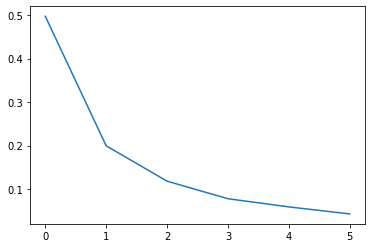

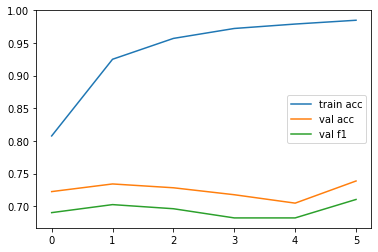

In [46]:
fig, ax = plt.subplots()
ax.plot(losses)
fig, ax = plt.subplots()
ax.plot(train_accuracies, label='train acc')
ax.plot(val_accuracies, label='val acc')
ax.plot(val_f1s, label='val f1')
ax.legend()
plt.savefig("learning_metrics.png")
plt.show()

In [42]:
print(train_model.stream_accuracy(clf, dl_val, device))

0.7415788789179347


In [43]:
print(train_model.stream_f1(clf, dl_val, device))

0.7109029348873568
